In [56]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

In [2]:
pth = '../data'
chp = xr.open_dataset(f'{pth}/chirps-v2.0.1981-2020.days_p05.nc', chunks={'time': 30})
bsl = xr.open_dataset(f'{pth}/pr_day_CNRM-CM6-1_historical_r1i1p1f2_gr_19500101-20141231_v20180917.nc', chunks={'time': 30})
ssp = xr.open_dataset(f'{pth}/pr_day_CNRM-CM6-1_ssp245_r1i1p1f2_gr_20150101-21001231_v20190219.nc', chunks={'time': 30})

In [3]:
# Ubah nama longitude dan latitude pada data CHIRPS menjadi lon dan lat
chp = chp.rename({'longitude': 'lon', 'latitude': 'lat', 'precip':'pr'})

In [4]:
# Cakupan area
lon1, lon2, lat1, lat2 = 108, 123, -4, 8
# Potong data sesuai cakupan area
chp = chp.sel(lon=slice(lon1, lon2), lat=slice(lat1, lat2))
bsl = bsl.sel(lon=slice(lon1, lon2), lat=slice(lat1, lat2))
ssp = ssp.sel(lon=slice(lon1, lon2), lat=slice(lat1, lat2))
# Periode waktu untuk koreksi
t1, t2 = '1981-01-01', '2010-12-31'
t3, t4 = '2021-01-01', '2050-12-31'
# Potong data sesuai periode waktu
chp = chp.sel(time=slice(t1, t2))
bsl = bsl.sel(time=slice(t1, t2))
ssp = ssp.sel(time=slice(t3, t4))

In [5]:
# Interpolasi CNRM-CM6-1 ke resolusi CHIRPS
resample_bsl = bsl.interp(coords = {
    'lat' : chp['lat'].values,
    'lon' : chp['lon'].values
}, method = 'linear', kwargs={"fill_value": "extrapolate"})

resample_ssp = ssp.interp(coords = {
    'lat' : chp['lat'].values,
    'lon' : chp['lon'].values
}, method = 'linear', kwargs={"fill_value": "extrapolate"})

In [6]:
# Kalikan dengan 86400 untuk mengubah satuan curah hujan dari kg/m2/detik menjadi mm/hari
# dan mengubah nilai curah hujan yang <1 mm/hari menjadi 0
# Baseline
resample_bsl['pr'] = resample_bsl['pr'] * 86400
resample_bsl['pr'] = xr.where(resample_bsl['pr'] < 1, 0, resample_bsl['pr'])
# SSP 245
resample_ssp['pr'] = resample_ssp['pr'] * 86400
resample_ssp['pr'] = xr.where(resample_ssp['pr'] < 1, 0, resample_ssp['pr'])

## Metode Delta

In [7]:
# Menghitung rataan semua waktu
# Baseline
bsl_mean = resample_bsl.mean(dim='time')
# SSP 245
ssp_mean = resample_ssp.mean(dim='time')

# Menghitung rasio rataan SSP 245 terhadap baseline
ratio = ssp_mean / bsl_mean

# Kalikan rasio dengan data CHIRPS
ssp_corrected = ratio * chp

# Transpose with time as first dimension
ssp_corrected = ssp_corrected.transpose('time', 'lat', 'lon')

# Mengubah waktu historis menjadi skenario SSP
ssp_corrected = ssp_corrected.assign(time=ssp.time)

In [25]:
ssp_corrected

<xarray.Dataset>
Dimensions:  (lat: 240, lon: 300, time: 10957)
Coordinates:
  * lat      (lat) float32 -3.975 -3.925 -3.875 -3.825 ... 7.875 7.925 7.975
  * lon      (lon) float32 108.0 108.1 108.1 108.2 ... 122.8 122.9 122.9 123.0
  * time     (time) datetime64[ns] 2021-01-01T12:00:00 ... 2050-12-31T12:00:00
Data variables:
    pr       (time, lat, lon) float64 dask.array<chunksize=(30, 240, 300), meta=np.ndarray>

In [52]:
# Jumlahkan curah hujan setiap bulan untuk setiap tahun
ssp_corrected_monthly = ssp_corrected.resample(time='M').sum(skipna=False)

# Rata-rata klimatologi bulanan
ssp_corrected_monthly_mean = ssp_corrected_monthly.groupby('time.month').mean(dim='time')
ssp_corrected_monthly_mean

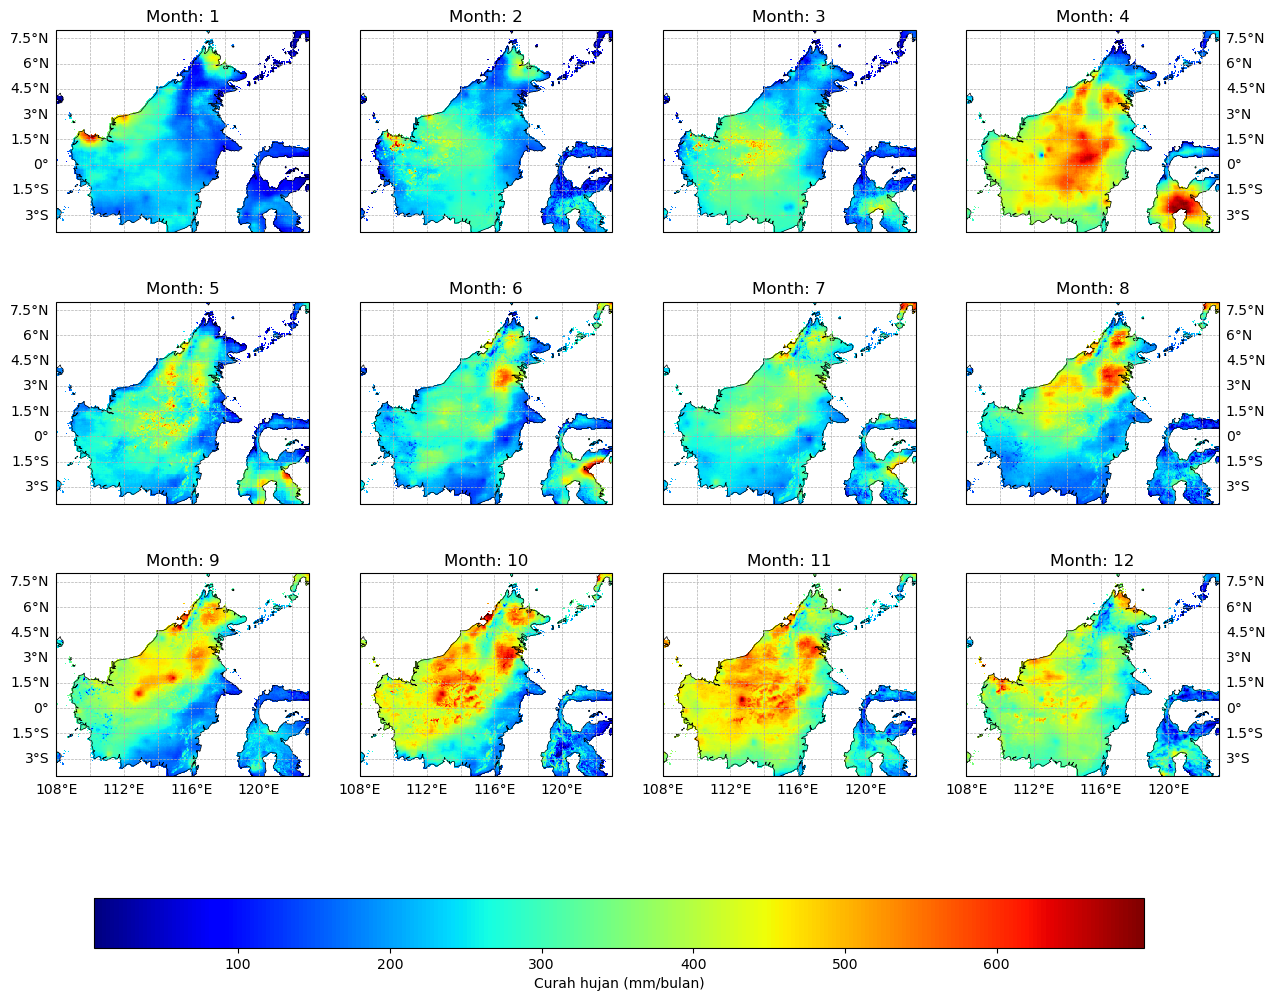

In [85]:
# Create a subplot of spatial plots for each month
fig, axes = plt.subplots(3, 4, figsize=(15, 10), subplot_kw={'projection': ccrs.PlateCarree()})
for month, ax in zip(range(1, 13), axes.ravel()):
    month_data = ssp_corrected_monthly_mean.sel(month=month)
    month_data = month_data['pr']
    month_data.plot.imshow(ax=ax, cmap='jet', add_colorbar=False, transform=ccrs.PlateCarree())

    # Menambahkan judul grafik dan garis pantai
    ax.set_title(f'Month: {month}')
    ax.coastlines(linewidth=0.5)

    # Menambahkan garis lintang dan bujur
    gl = ax.gridlines(draw_labels=True, linestyle='--', linewidth=0.5)

    # Menghilangkan label untuk beberapa plot agar tidak terlalu padat
    if month in [2, 3, 4, 6, 7, 8, 10, 11, 12]:
        gl.left_labels = False
    if month in [1, 2, 3, 4, 5, 6, 7, 8]:
        gl.bottom_labels = False
    if month not in [4, 8, 12]:
        gl.right_labels = False
    gl.top_labels = False

# Menambahkan colorbar
cbar_ax = fig.add_axes([0.15, -0.05, 0.7, 0.05])
fig.colorbar(ax.images[0], cax=cbar_ax, orientation='horizontal', label='Curah hujan (mm/bulan)')

plt.show()

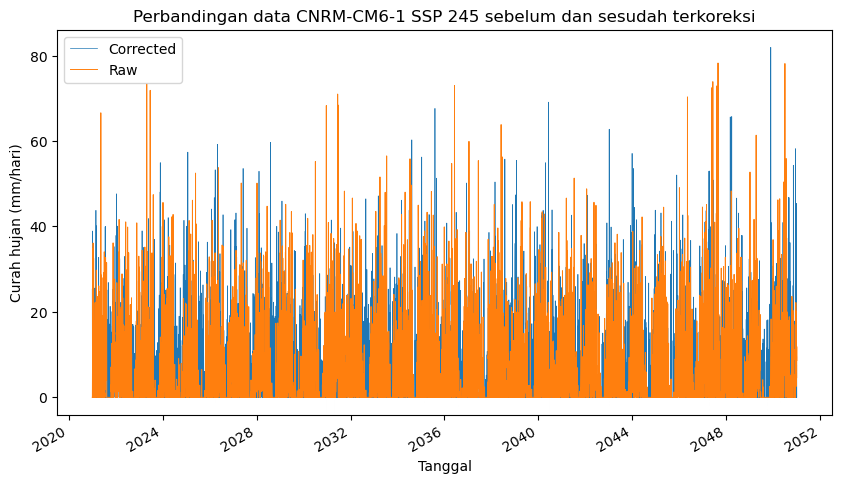

In [88]:
# Membuat plot
fig, ax = plt.subplots(figsize=(10, 5))
# Memilih data untuk setiap bulan
lat, lon = -3.322423232458966, 114.59597874153853
ssp_corrected.pr.sel(lat=lat, lon=lon, method='nearest').plot(ax=ax, label='Corrected', linewidth=0.5)
resample_ssp.pr.sel(lat=lat, lon=lon, method='nearest').plot(ax=ax, label='Raw', linewidth=0.7)
# Menambahkan judul grafik
ax.set_title('Perbandingan data CNRM-CM6-1 SSP 245 sebelum dan sesudah terkoreksi')
# Menambahkan label sumbu x dan y
ax.set_xlabel('Tanggal')
ax.set_ylabel('Curah hujan (mm/hari)')
# Menambahkan legend
ax.legend()
plt.show()

## Metode Distribusi Statistik